In [3]:
import numpy as np
import scipy.stats
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML
import random


plt.rcParams['figure.figsize'] = [10, 10]

In [4]:
class DirichletMultinomial:
    def __init__(self, thetas, alphas):
        self.thetas = thetas
        self.alphas = alphas
    
    def likelihood(self, data):
        return np.prod(np.power(self.thetas, self.data_counts(data)))
    
    def likelihood2(self, data):
        return scipy.stats.multinomial.pmf(self.data_counts(data), n=len(data), p=self.thetas)
    
    def prior(self):
        return scipy.stats.dirichlet.pdf(self.thetas, self.alphas)

    def posterior(self, data):
        return scipy.stats.dirichlet.pdf(self.thetas, np.array(self.alphas) + np.array(self.data_counts(data)))
    
    def posterior_prediction(self, data):
        data_counts = self.data_counts(data)
        return (np.array(self.alphas) + np.array(data_counts)) / (np.sum(data_counts) + np.sum(self.alphas))
                                                
    def data_counts(self, data):
        return [data.count(k) for k in range(len(self.thetas))]

In [8]:
model = DirichletMultinomial(thetas=[0.5, 0.5], alphas=[2, 2])
data = [0, 1]
print(model.likelihood(data))
print(model.likelihood2(data))
print(model.prior())
print(model.posterior(data))
print(model.posterior_prediction(data))

0.25
0.5
1.5
1.8749999999999996
[0.5 0.5]


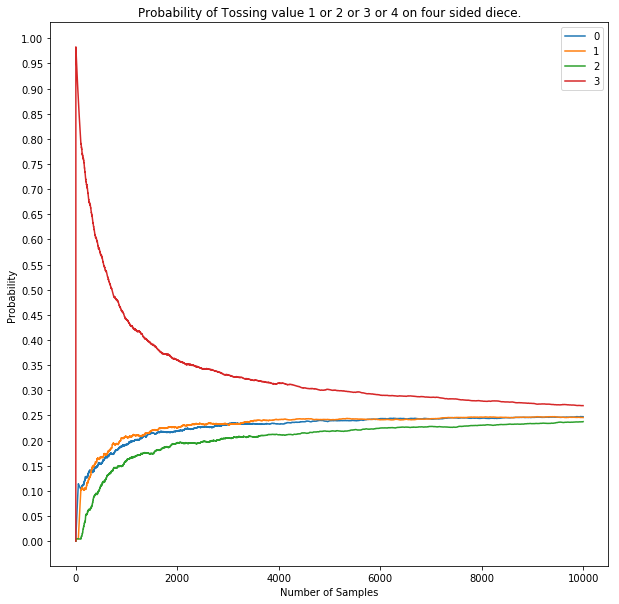

In [108]:
p = 50
p1 = [0] * p
p2 = [1] * p


data = p1 + p2 + np.random.randint(4, size=9900).tolist()
model = DirichletMultinomial(thetas=[0.25, 0.25, 0.25, 0.25], alphas=[2, 2, 2, 400])
results = np.zeros(shape=(10000, 4))

for i in range(1, len(data)):
    results[i, :] = model.posterior_prediction(data[:i])

plt.plot(np.arange(len(data)), results[:, 0], label="0")
plt.plot(np.arange(len(data)), results[:, 1], label="1")
plt.plot(np.arange(len(data)), results[:, 2], label="2")
plt.plot(np.arange(len(data)), results[:, 3], label="3")
plt.xlabel('Number of Samples')
plt.ylabel('Probability')
plt.yticks(np.arange(0, 1.05, step=0.05))
plt.title("Probability of Tossing value 1 or 2 or 3 or 4 on four sided diece.")
plt.legend()
plt.show()

In [128]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string

exclude = set(string.punctuation)
wnl = WordNetLemmatizer()

def remove_punctuation_split(text):
    return ''.join(ch for ch in text if ch not in exclude).split()

def filter_non_english_words(word_list):
    return [word for word in word_list if word not in stopwords.words('english')]
    
def dictionary_from_word_list(word_list):
    return dict((x,word_list.count(x)) for x in set(word_list))

def lematize(word_list):
    return [wnl.lemmatize(i) for i in word_list]

def get_text(filename):
    with open(filename, 'r') as myfile:
        return myfile.read()

def get_dict_from_text(text, lem):
    tokenized = remove_punctuation_split(text)
    words = filter_non_english_words(tokenized)
    if lem:
        words = lematize(words)
    dictionary = dictionary_from_word_list(words)
    
    return dictionary

def get_words(text):
    tokenized = remove_punctuation_split(text)
    return filter_non_english_words(tokenized)

def probability_predictive(alphas, occurences):
    return [(alphas[i] + occurences[i])/(sum(alphas) + sum(occurences)) for i in range(len(alphas))]
    
def get_top_predictions(text, num_res=10):
    dictionary = get_dict_from_text(text, lem=True)
    alphas = [1] * len(dictionary)
    occurences = list(dictionary.values())
    predictions = probability_predictive(alphas, occurences)
    i = 0
    tuples = []
    for key, val in dictionary.items():
        tuples.append((key, predictions[i]))
        i += 1
    return [tuples[i] for i in np.argsort(predictions)[-num_res:]]

def calculate_accuracy(text, num_words, top=1):
    good_preds = 0
    words = get_words(text)
    split_index = len(words) - num_words
    for i in range(split_index, len(words)):
        text = ' '.join(words[:split_index])
        predictions = get_top_predictions(text, num_res=top)
        actual_word = words[i]
#         print("Actual: {}".format(actual_word))
        if actual_word in [elem[0] for elem in predictions]:
            good_preds += 1
    return good_preds / num_words


In [129]:
import operator
text = get_text('californication.txt').lower()
tokenized_text = get_words(text)
dictionary = get_dict_from_text(text, lem=True)
sorted_dictionary = sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)
print("Most common words:")
for w in sorted_dictionary[:10]:
    print(w)

print()
print("Sample top words prediction:")
sample_text = text[:1000]
pred = get_top_predictions(sample_text, num_res=10)
for p in pred:
    print(p)
print()

print("Top Accuracy = {}".format(calculate_accuracy(text, 50, top=5)))

Most common words:
('californication', 17)
('dream', 14)
('girl', 3)
('unicorn', 3)
('firstborn', 3)
('soft', 3)
('hardcore', 3)
('world', 3)
('porn', 3)
('break', 2)

Sample top words prediction:
('star', 0.011834319526627219)
('high', 0.011834319526627219)
('world', 0.01775147928994083)
('girl', 0.01775147928994083)
('hollywood', 0.01775147928994083)
('final', 0.01775147928994083)
('may', 0.01775147928994083)
('station', 0.01775147928994083)
('dream', 0.04142011834319527)
('californication', 0.047337278106508875)

Top Accuracy = 0.34
